Data Shape: (777, 10)
   index      Country         Region  Happiness Rank  \
0    153  Afghanistan  Southern Asia             154   
1    152  Afghanistan  Southern Asia             153   
2    144  Afghanistan            NaN             145   
3    153  Afghanistan            NaN             154   
4    140  Afghanistan            NaN             141   

   Economy (GDP per Capita)    Family  Health (Life Expectancy)  Freedom  \
0                  0.382270  0.110370                  0.173440  0.16430   
1                  0.319820  0.302850                  0.303350  0.23414   
2                  0.332000  0.537000                  0.255000  0.08500   
3                  0.350000  0.517000                  0.361000  0.00000   
4                  0.401477  0.581543                  0.180747  0.10618   

   Trust (Government Corruption)  Generosity  
0                       0.071120    0.312680  
1                       0.097190    0.365100  
2                       0.036000    0.19100

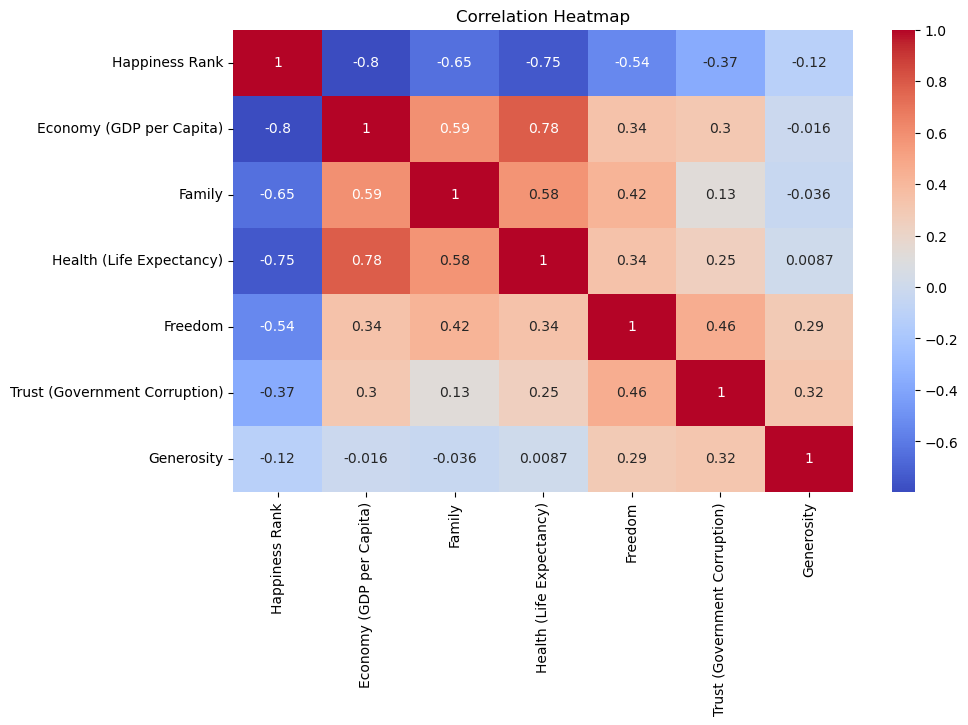

Index(['Happiness Rank', 'Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity'],
      dtype='object')


In [74]:
%run eda.ipynb

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    ExtraTreesRegressor, AdaBoostRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error


In [76]:
try:
    from xgboost import XGBRegressor
    xgb_available = True
except ImportError:
    xgb_available = False

In [77]:
X = df.drop("Happiness Rank", axis=1)
y = df["Happiness Rank"]

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [79]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "KNN Regressor": KNeighborsRegressor()
}

In [80]:
if xgb_available:
    models["XGBoost"] = XGBRegressor(objective="reg:squarederror")

In [81]:
results = {}

In [82]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [83]:
for name, model in models.items():
    cv_r2 = cross_val_score(model, X_train, y_train, cv=cv, scoring="r2")
    cv_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_mean_squared_error"))
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    test_r2 = r2_score(y_test, preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    results[name] = {
        "CV_R2_mean": cv_r2.mean(),
        "CV_R2_std": cv_r2.std(),
        "CV_RMSE_mean": cv_rmse.mean(),
        "Test_R2": test_r2,
        "Test_RMSE": test_rmse,
        "model": model
    }
    print(f"{name}:")
    print(f"  CV R²={cv_r2.mean():.4f} ± {cv_r2.std():.4f}, CV RMSE={cv_rmse.mean():.4f}")
    print(f"  Test R²={test_r2:.4f}, Test RMSE={test_rmse:.4f}\n")

Linear Regression:
  CV R²=0.7576 ± 0.0264, CV RMSE=22.1784
  Test R²=0.7287, Test RMSE=23.5055

Ridge Regression:
  CV R²=0.7580 ± 0.0271, CV RMSE=22.1612
  Test R²=0.7293, Test RMSE=23.4807

Lasso Regression:
  CV R²=0.7282 ± 0.0354, CV RMSE=23.4810
  Test R²=0.7095, Test RMSE=24.3250

Random Forest:
  CV R²=0.7855 ± 0.0216, CV RMSE=20.6333
  Test R²=0.7908, Test RMSE=20.6423

Gradient Boosting:
  CV R²=0.7860 ± 0.0238, CV RMSE=20.7892
  Test R²=0.7558, Test RMSE=22.3033

AdaBoost:
  CV R²=0.7501 ± 0.0272, CV RMSE=22.6455
  Test R²=0.7177, Test RMSE=23.9796

KNN Regressor:
  CV R²=0.7727 ± 0.0330, CV RMSE=21.4009
  Test R²=0.8190, Test RMSE=19.1985



In [84]:
best_model = max(results, key=lambda k: results[k]["CV_R2_mean"])
print("\n Best Model:", best_model, 
      "with CV R²:", results[best_model]["CV_R2_mean"], 
      "and Test R²:", results[best_model]["Test_R2"])


 Best Model: Gradient Boosting with CV R²: 0.7860183844385864 and Test R²: 0.7557800067875411


In [85]:
r2_scores = {k: v["CV_R2_mean"] for k, v in results.items()}
rmse_scores = {k: v["CV_RMSE_mean"] for k, v in results.items()}

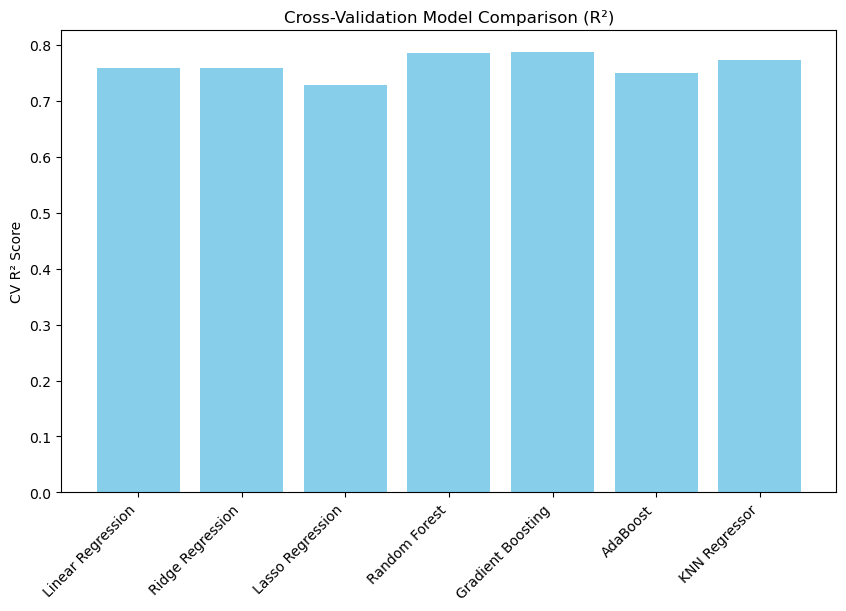

In [86]:
plt.figure(figsize=(10,6))
plt.bar(r2_scores.keys(), r2_scores.values(), color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("CV R² Score")
plt.title("Cross-Validation Model Comparison (R²)")
plt.show()

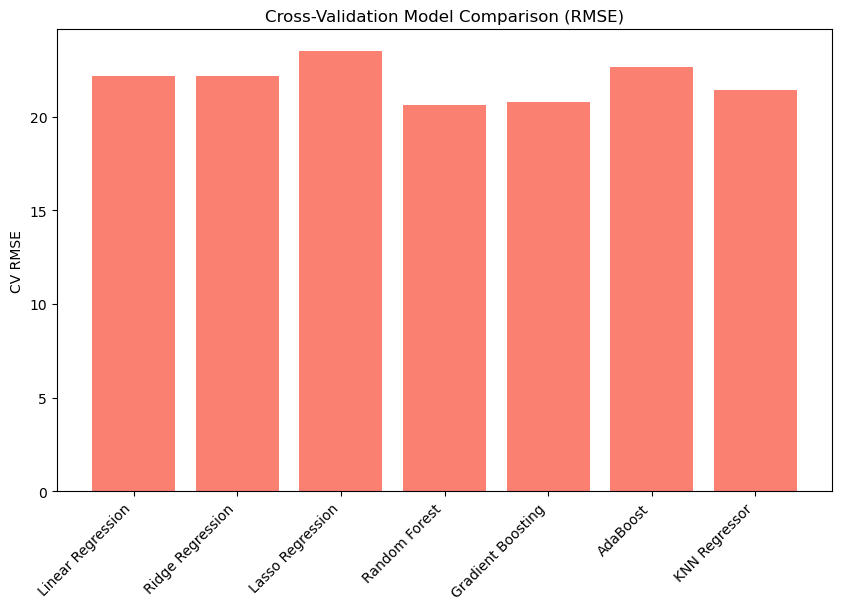

In [87]:
plt.figure(figsize=(10,6))
plt.bar(rmse_scores.keys(), rmse_scores.values(), color="salmon")
plt.xticks(rotation=45, ha="right")
plt.ylabel("CV RMSE")
plt.title("Cross-Validation Model Comparison (RMSE)")
plt.show()

In [88]:
sorted_models = sorted(results.items(), key=lambda kv: kv[1]["CV_R2_mean"], reverse=True)
top_models = [m[0] for m in sorted_models[:2]]
print("\n🔍 Top models selected for hyperparameter tuning:", top_models)


🔍 Top models selected for hyperparameter tuning: ['Gradient Boosting', 'Random Forest']


In [89]:
best_estimators = {}

In [90]:
if "Random Forest" in top_models:
    rf_params = {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10]
    }
    rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params,
                           cv=5, scoring="r2", n_jobs=-1)
    rf_grid.fit(X_train, y_train)
    best_estimators["Random Forest"] = rf_grid.best_estimator_
    print("\n Random Forest Best Params:", rf_grid.best_params_)
    print("Best CV R²:", rf_grid.best_score_)

if "Gradient Boosting" in top_models:
    gb_params = {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7]
    }
    gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params,
                           cv=5, scoring="r2", n_jobs=-1)
    gb_grid.fit(X_train, y_train)
    best_estimators["Gradient Boosting"] = gb_grid.best_estimator_
    print("\n Gradient Boosting Best Params:", gb_grid.best_params_)
    print("Best CV R²:", gb_grid.best_score_)



 Random Forest Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Best CV R²: 0.7949368042917959

 Gradient Boosting Best Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
Best CV R²: 0.7932004998649436


In [91]:
for name, model in best_estimators.items():
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"\n Final Tuned {name}: Test R²={r2:.4f}, Test RMSE={rmse:.4f}")


 Final Tuned Random Forest: Test R²=0.7935, Test RMSE=20.5073

 Final Tuned Gradient Boosting: Test R²=0.7774, Test RMSE=21.2946


In [92]:
import joblib

joblib.dump(best_estimators["Random Forest"], "best_model.pkl")

best_model = joblib.load("best_model.pkl")


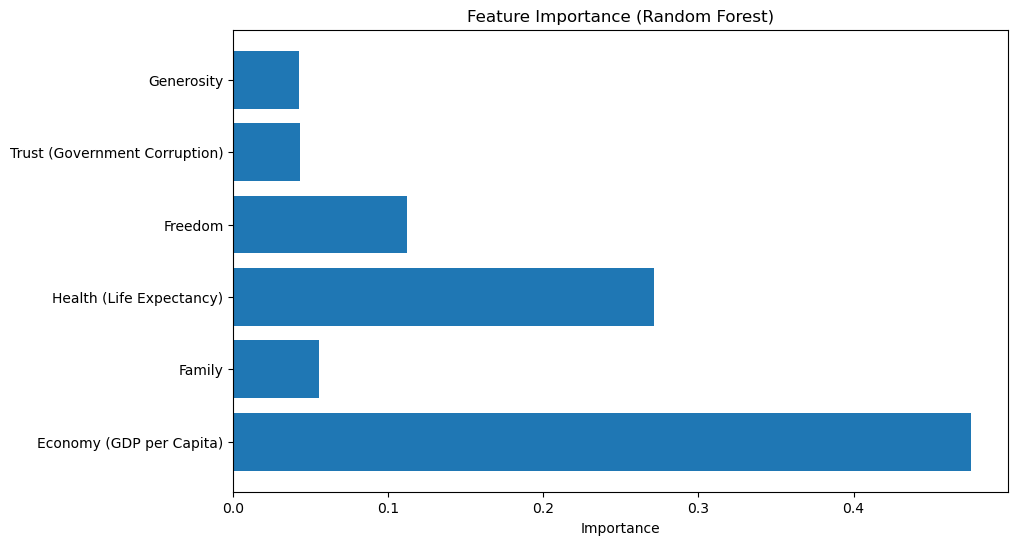

In [93]:
import matplotlib.pyplot as plt

rf_model = best_estimators["Random Forest"]
importances = rf_model.feature_importances_
features = X.columns

plt.figure(figsize=(10,6))
plt.barh(features, importances)
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()